# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

### Подгрузка основных библиотек и самого датасета

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,accuracy_score,confusion_matrix

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Загрузили библиотеки, посмотрели на наши данные.

### Заполнение пропусков и приведение к нужным типам

In [5]:
data.loc[data['Tenure'].isna(), 'Tenure'] = [random.randint(0,10) for i in range(sum(data['Tenure'].isna()))]
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Для лучшего обучения модели пропуски в количестве недвижимости заполнили случайными значениями от 0 до 10.

In [6]:
data=data.drop(columns='RowNumber')
data['Balance']=data['Balance'].astype('int')
data['EstimatedSalary']=data['EstimatedSalary'].astype('int')
data['Tenure']=data['Tenure'].astype('int')
data

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0,1,1,1,101348,1
1,15647311,Hill,608,Spain,Female,41,1,83807,1,0,1,112542,0
2,15619304,Onio,502,France,Female,42,8,159660,3,1,0,113931,1
3,15701354,Boni,699,France,Female,39,1,0,2,0,0,93826,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510,1,1,1,79084,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,Obijiaku,771,France,Male,39,5,0,2,1,0,96270,0
9996,15569892,Johnstone,516,France,Male,35,10,57369,1,1,1,101699,0
9997,15584532,Liu,709,France,Female,36,7,0,1,0,1,42085,1
9998,15682355,Sabbatini,772,Germany,Male,42,3,75075,2,1,0,92888,1


Все типы привели к целым числам.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null int64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null int64
Exited             10000 non-null int64
dtypes: int64(10), object(3)
memory usage: 1015.8+ KB


In [8]:
data['Gender']=pd.get_dummies(data['Gender'], drop_first=True)
data

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,0,42,2,0,1,1,1,101348,1
1,15647311,Hill,608,Spain,0,41,1,83807,1,0,1,112542,0
2,15619304,Onio,502,France,0,42,8,159660,3,1,0,113931,1
3,15701354,Boni,699,France,0,39,1,0,2,0,0,93826,0
4,15737888,Mitchell,850,Spain,0,43,2,125510,1,1,1,79084,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,Obijiaku,771,France,1,39,5,0,2,1,0,96270,0
9996,15569892,Johnstone,516,France,1,35,10,57369,1,1,1,101699,0
9997,15584532,Liu,709,France,0,36,7,0,1,0,1,42085,1
9998,15682355,Sabbatini,772,Germany,1,42,3,75075,2,1,0,92888,1


In [9]:
data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [10]:
data=pd.get_dummies(data,columns=['Geography'], drop_first=True)
data

,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,15634602,Hargrave,619,0,42,2,0,1,1,1,101348,1,0,0
1,15647311,Hill,608,0,41,1,83807,1,0,1,112542,0,0,1
2,15619304,Onio,502,0,42,8,159660,3,1,0,113931,1,0,0
3,15701354,Boni,699,0,39,1,0,2,0,0,93826,0,0,0
4,15737888,Mitchell,850,0,43,2,125510,1,1,1,79084,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,Obijiaku,771,1,39,5,0,2,1,0,96270,0,0,0
9996,15569892,Johnstone,516,1,35,10,57369,1,1,1,101699,0,0,0
9997,15584532,Liu,709,0,36,7,0,1,0,1,42085,1,0,0
9998,15682355,Sabbatini,772,1,42,3,75075,2,1,0,92888,1,1,0


Закодировали категориальные столбцы.

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
CustomerId           10000 non-null int64
Surname              10000 non-null object
CreditScore          10000 non-null int64
Gender               10000 non-null uint8
Age                  10000 non-null int64
Tenure               10000 non-null int64
Balance              10000 non-null int64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null int64
Exited               10000 non-null int64
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
dtypes: int64(10), object(1), uint8(3)
memory usage: 888.8+ KB


### Проверка на мультиколлинеарность

In [12]:
data.corr()

,CustomerId,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
CustomerId,1.000000,0.005308,-0.002641,0.009497,-0.016405,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248,-0.003097,0.007800
CreditScore,0.005308,1.000000,-0.002857,-0.003965,0.001074,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,0.005538,0.004780
Gender,-0.002641,-0.002857,1.000000,-0.027544,0.014647,0.012087,-0.021859,0.005766,0.022544,-0.008112,-0.106512,-0.024628,0.016889
Age,0.009497,-0.003965,-0.027544,1.000000,-0.007120,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,0.046897,-0.001685
Tenure,-0.016405,0.001074,0.014647,-0.007120,1.000000,-0.003976,0.015437,0.023974,-0.030148,0.011460,-0.011636,-0.003082,0.001261
Balance,-0.012419,0.006268,0.012087,0.028308,-0.003976,1.000000,-0.304179,-0.014858,-0.010084,0.012798,0.118533,0.401110,-0.134892
NumOfProducts,0.016972,0.012238,-0.021859,-0.030680,0.015437,-0.304179,1.000000,0.003183,0.009612,0.014204,-0.047820,-0.010419,0.009039
HasCrCard,-0.014025,-0.005458,0.005766,-0.011721,0.023974,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.010577,-0.013480
IsActiveMember,0.001665,0.025651,0.022544,0.085472,-0.030148,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,-0.020486,0.016732
EstimatedSalary,0.015271,-0.001384,-0.008112,-0.007201,0.011460,0.012798,0.014204,-0.009933,-0.011421,1.000000,0.012097,0.010297,-0.006482


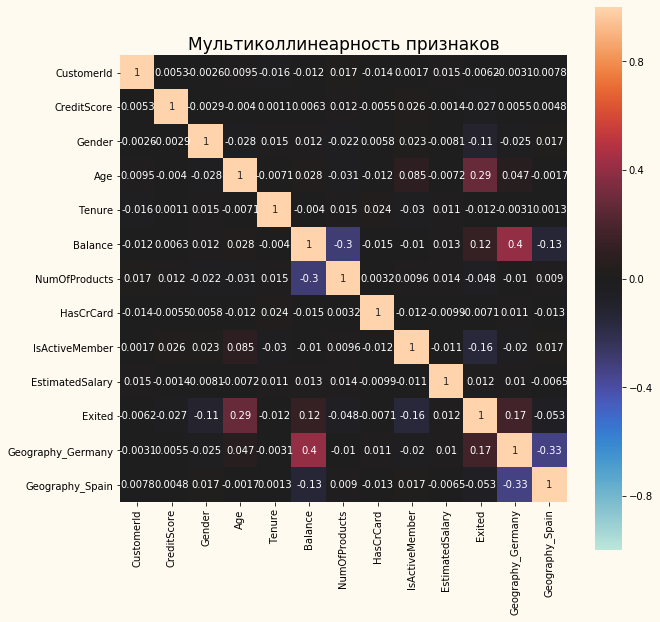

In [13]:
fig, ax = plt.subplots()
sns.heatmap(data.corr(),vmin=-1, vmax=1, center= 0,square=True,annot=True)
ax.set_facecolor('seashell')
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_facecolor('floralwhite')
plt.title('Мультиколлинеарность признаков', fontsize=17)
plt.show()

Сильнозависимых признаков нет, значит ничего лишнего удалять не будем.

### Разбиение на выборки

In [14]:
target = data['Exited']
features = data.drop(['Exited','Surname'], axis=1)

Разделили нашу таблицу на две части: обучищий набор(убрали фамилии из признаков) и целевой признак.

In [15]:
features_new, features_valid, target_new, target_valid = train_test_split(
    features, target, test_size=0.2,train_size=0.8, random_state=12345)

Сделали две выборки в отношении 20% на 80%: новую и валидационную.

In [16]:
features_train, features_test, target_train, target_test = train_test_split(
    features_new, target_new, test_size=0.25,train_size=0.75, random_state=12345)

Новую поделили еще в отношении 1 на 4. И получили 60% от общих данных для тренировки и 20% для теста.

In [17]:
display(features_train.shape,target_valid.shape,target_test.shape)

(6000, 12)

(2000,)

(2000,)

Размеры выборок соответствуют нашим ожиданиям.

### Стандартизация

In [18]:
scaler = StandardScaler()
scaler.fit(features_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [19]:
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)
features_valid_scaled = scaler.transform(features_valid)

Привели все наши выборки к одному стандарту.

## Исследование задачи

### Логистическая регрессия

In [20]:
model = LogisticRegression(random_state=12345)
model.fit(features_train_scaled, target_train)
predicted_valid = model.predict(features_valid_scaled)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.30313588850174217


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Решающее дерево

In [21]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train_scaled, target_train)
predicted_valid = model.predict(features_valid_scaled)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.46209386281588444


### Случайный лес

In [22]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train_scaled,target_train)
predicted_valid = model.predict(features_valid_scaled)
result = f1_score(target_valid, predicted_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.46209386281588444


In [23]:
data['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Баланс в нашей выборке распределен в соотношении почти 20 на 80.

Наши модели, без учёта баланса, показывают достаточно слабые результаты. Проверка на баланс показала сильный перевес в сторону 0 значений. Далее попробуем разными методами устранить дисбаланс.

## Борьба с дисбалансом

### Логистическая регрессия со взешиванием классов

In [24]:
model = LogisticRegression(random_state=12345,class_weight='balanced')
model.fit(features_train_scaled, target_train)
predicted_valid = model.predict(features_valid_scaled)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5004212299915755


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Решающее дерево с балансом

In [25]:
%%time
best_model = None
best_result = 0
for crit in ['gini','entropy']:
    for split in range(2,11):
        for leaf in range(1,11):
            for depth in range(1, 11):
                model = DecisionTreeClassifier(random_state=12345, max_depth=depth,criterion=crit,min_samples_split=split,min_samples_leaf=leaf,class_weight='balanced')
                model.fit(features_train_scaled,target_train)
                predicted_valid = model.predict(features_valid_scaled)
                result = f1_score(target_valid, predicted_valid)
                if result > best_result:
                    best_model = model
                    best_result = result
                    best_depth=depth
                    best_crit=crit
                    best_split=split
                    best_leaf=leaf
print('Лучший результат F1:',best_result)
print('При глубине дерева',best_depth,', критерии',best_crit,', количества узлов',best_split,'и числа объектов в узлах',best_leaf)

Лучший результат F1: 0.6152324431256181
При глубине дерева 6 , критерии entropy , количества узлов 2 и числа объектов в узлах 3
CPU times: user 51.2 s, sys: 21 ms, total: 51.2 s
Wall time: 52 s


### Случайный лес с балансом

In [26]:
%%time
best_esti=0

for depth in range(7, 11):
    for esti in range(10, 501,10):
        model = RandomForestClassifier(random_state=12345, n_estimators=esti,max_depth=depth,criterion=best_crit,class_weight='balanced') 
        model.fit(features_train_scaled,target_train)
        predicted_valid = model.predict(features_valid_scaled)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_depth=depth
            best_esti=esti
            print(best_depth, best_esti, best_result)
print('Лучший результат:',best_result)
if best_esti==0:
    print('Эти модели были хуже')
else:
    print('При глубине дерева',best_depth,', критерии',best_crit,'и количества деревьев',best_esti)

7 10 0.6430020283975659
7 30 0.6430738119312437
7 40 0.6455566905005107
7 80 0.646817248459959
8 40 0.6531049250535332
9 60 0.6547884187082404
9 100 0.6548672566371682
9 120 0.6571113561190739
9 130 0.6592427616926503
Лучший результат: 0.6592427616926503
При глубине дерева 9 , критерии entropy и количества деревьев 130
CPU times: user 8min 16s, sys: 1.31 s, total: 8min 17s
Wall time: 8min 26s


In [27]:
predicted_test = best_model.predict(features_test_scaled)
result = f1_score(target_test, predicted_test)
print('На тестовой:',result)

На тестовой: 0.5930372148859544


### Увеличение выборки

In [28]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [29]:
%%time
cd=False
for rep in range(1,20):
    features_upsampled, target_upsampled = upsample(features_train, target_train, rep)
    model = RandomForestClassifier(random_state=12345, n_estimators=best_esti,max_depth=best_depth,criterion=best_crit,class_weight='balanced')
    model.fit(features_upsampled,target_upsampled)
    predicted_valid=model.predict(features_valid)
    result=f1_score(target_valid, predicted_valid)
    if result>best_result:
        best_result=result
        best_model=model
        best_rep=rep/10
        cd=True
if cd==True:
    print("Лучшая модель показала F1:", f1_score(target_valid, predicted_valid), 'при увеличении положительных ответов в', best_rep, 'раза')
else:
    print('Эти модели были хуже')

Эти модели были хуже
CPU times: user 50.8 s, sys: 104 ms, total: 50.9 s
Wall time: 52.2 s


Фунции на вход получаеют объект типа Series и подстановка стандартизированных значений(двумерный массив) здесь и ниже не подошла.

### Уменьшение выборки

In [30]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [31]:
%%time
cd=False
for rep in range(10,0,-1):
    features_downsampled, target_downsampled = downsample(features_train, target_train, rep/10)
    model = RandomForestClassifier(random_state=12345, n_estimators=best_esti,max_depth=best_depth,criterion=best_crit,class_weight='balanced')
    model.fit(features_upsampled,target_upsampled)
    predicted_valid=model.predict(features_valid)
    result=f1_score(target_valid, predicted_valid)
    if result>best_result:
        best_result=result
        best_model=model
        best_rep=rep/10
        cd=True
if cd==True:
    print("Лучшая модель показала F1:", f1_score(target_valid, predicted_valid), 'при уменьшении положительных ответов в', best_rep, 'раза')
else:
    print('Эти модели были хуже')

Эти модели были хуже
CPU times: user 39.1 s, sys: 60 ms, total: 39.2 s
Wall time: 41.1 s


## Тестирование модели

### Проверка на тестовой выборке

In [32]:
predicted_test = best_model.predict(features_test_scaled)
result = f1_score(target_test, predicted_test)
print('На тестовой:',result)

На тестовой: 0.5930372148859544


In [33]:
print(confusion_matrix(target_test, predicted_test))

[[1414  195]
 [ 144  247]]


### ROC-кривая

In [34]:
probabilities_test = best_model.predict_proba(features_test_scaled)
probabilities_one_test = probabilities_test[:, 1]

auc_roc=roc_auc_score(target_test,probabilities_one_test)

print(auc_roc)

0.8505258941472122


In [35]:
probabilities_valid = best_model.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc=roc_auc_score(target_valid,probabilities_one_valid)

print(auc_roc)

0.8674082995990596


In [36]:
fpr, tpr, thresholds = roc_curve(target_valid,probabilities_one_valid)

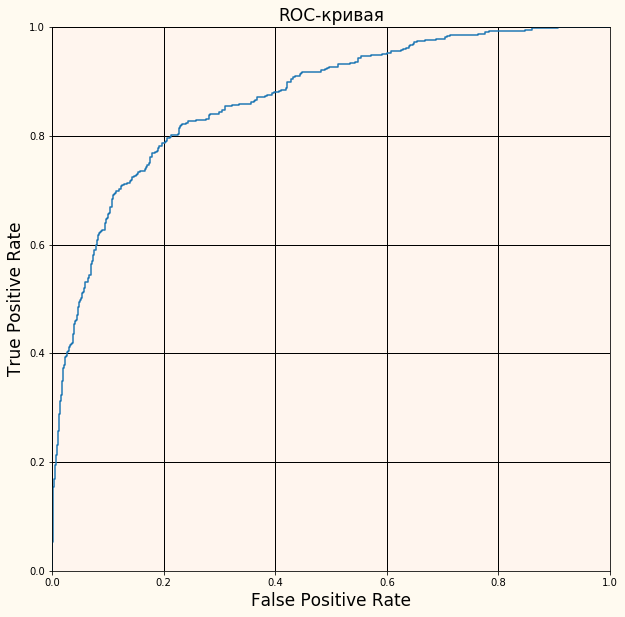

In [37]:
fig, ax = plt.subplots()
plt.plot(fpr,tpr)
plt.grid(color='black', linestyle='-', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=17)
plt.ylabel('True Positive Rate', fontsize=17)
plt.title('ROC-кривая', fontsize=17)
ax.set_facecolor('seashell')
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_facecolor('floralwhite')
plt.show()

Кривая ошибок гораздо выше главной диагонали - это хорошо.

### Проверка на адекватность

In [38]:
features_adept=features_test['CreditScore']*0
features_adept.head()

2358    0
8463    0
163     0
3074    0
5989    0
Name: CreditScore, dtype: int64

In [39]:
result = accuracy_score(target_test, features_adept)
result

0.8045

In [40]:
result = f1_score(target_test, features_adept)
result

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [41]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_valid, target_valid)
dummy_clf.score(features_valid, target_valid)

0.7865

Метрики соответствия на банальных моделях показали достаточно высокие результаты, но F1 нас спасло и указала на неадекватность модели.

## Вывод

- Наша исходная выборка оказалась сильно несбалансирована, что даже с случайной моделью мы получаем 80%. 
- Смогли перебрать несклько типов моделей без учета баланса, улучшили наши показатели полноты и точности с помощью меры F1 до 0.48.
- Перебрали несколько выриантов борьбы с балансом, наилучшим методом стала развесовка классов, искусственные увеличение и уменьшение выборки нам не помогли.
- Проверили нашую лучшую модель на тестовой выборке и получили результат в районе 0.59 (значение варьируется при разных запусках).

Наша модель учитывает баланс, показывает неплохие результаты и готова выходить в свет!

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*